# Resonator qbit driven shit

This experiment measures the qubit driven shift of the resonator. When the qubit is excited to the $\ket{1}$ state the resonator frequency shifts due to its dispersive coupling to the qubit, in CW, the spectrum of the resonator shows both of the qubit states (qubit at $\ket{0}$ and $\ket{1}$) as two Lorentzian peaks. One peak is at $\omega_r$ and the second at $\omega_r+2g^2/\Delta$, where $\Delta$ is the difference between the resonator and the qubit.

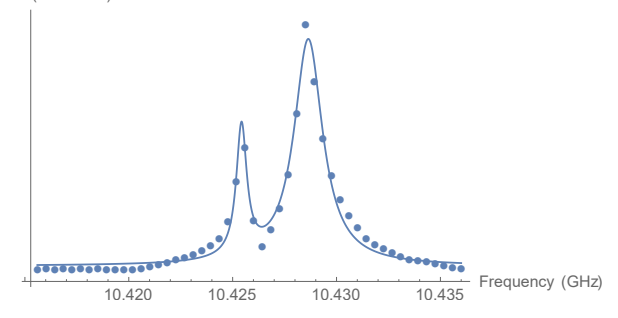

Photon Induced Decoherence of a Transmon Superconducting Charge Qubit, P. Leek, 2018

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from HelpModule import *
from E5080B_driver import *
from SGS100A_driver import *
from IPython.display import clear_output
from time import sleep

lo = SGS100A_driver('TCPIP0::192.168.0.32::inst0::INSTR')
vna = E5080B_driver('TCPIP0::192.168.0.235::inst0::INSTR')
meas_ = 'S21'
twpa_on = False
if twpa_on:
    twpa = SGS100A_driver('TCPIP0::192.168.0.34::inst0::INSTR')
else:
    twpa = SGS100A_driver('dummy')
    
vna.open()
f_c = 0

Could not connect to dummy


In [24]:
from datetime import datetime

params={}
params['test_date'] = datetime.today().strftime('%Y%m%d_%H%M')
params['test_type'] = 'resonator_sweep_qubitdriven'

# Qubit Parameters
params['qubit_name'] = '2QCRC3'
params['qubit_power'] = -8
params['qubit_freq'] = 4.28000e9
params['twpa_power'] = 0.0
params['twpa_frequency'] = 0.0
params['twpa_on'] = False
params['vna_power'] = -70 #Single Photon Regime
params['center_freq'] = 6843650000.00 
params['span_freq'] = 20
params['flux_curr'] = 0
params['temp'] = 22.2
params['comment'] = "# 2QCRC3\n" +\
                    "# No TWPA " +\
                    "# " +\
                    "# " +\
                    "# \n"


# Sweep Parameters
params['qubit_power_i'] = 9
params['qubit_power_f'] = -22
params['qubit_power_step'] = -3
npoints = 2001

qubit_pow_array = np.arange(params['qubit_power_i'],params['qubit_power_f'],params['qubit_power_step'])
avg_time = 30

# Turn on the TWPA if necessary
if twpa_on:
    twpa.set_RF(params['twpa_frequency'])
    twpa.set_level(params['twpa_power']) # dBm
    twpa.start_rf()
    
# Check that the f of the resonator is correct 
if f_c == 0:
    freqs, mag, phase = meas_spectrum(vna, params['center_freq'] ,f_span=10,power=-65, npoints=201,sleep_t = 10)
    f_c, Qf, fwhm = Q(freqs,mag, True)


In [25]:
# Intialize sweep
vna.set_sweep_npoints(npoints)
vna.set_center_frequency(f_c)
vna.set_span_frequency(params['span_freq'])

sleep(1)
freqs = vna.get_freq_array()
vna.set_power(params['vna_power'],overule_power=True)

mags    = np.ndarray((len(qubit_pow_array),npoints))
phases  = np.ndarray((len(qubit_pow_array),npoints))
Z       = np.ndarray((len(qubit_pow_array),npoints), dtype=complex)

mags[:]     = 0.
phases[:]   = 0.
Z[:]        = 0.

with lo:
    lo.set_RF(params['qubit_freq']*1e-3)
    lo.set_level(qubit_pow_array[0])
    lo.start_rf()

vna.start_rf()

if twpa_on:
    twpa.set_RF(params['twpa_frequency'])
    twpa.set_level(params['twpa_power']) # dBm
    twpa.start_rf()

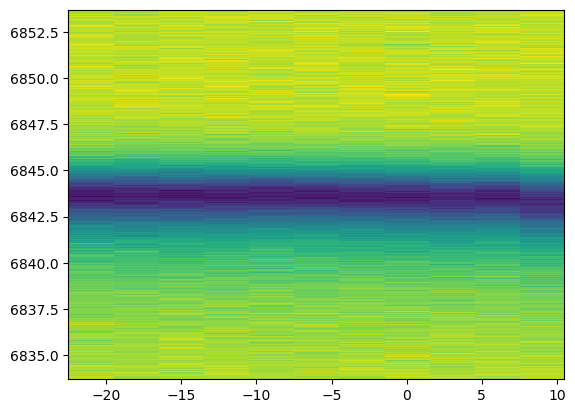

file saved as resonator_sweep_qubitdriven_2QCRC3_20240507_1203


In [26]:

# Run the sweep
try:
    for idx,power in enumerate(qubit_pow_array):
        clear_output(wait=True)
        with lo:
            lo.set_level(power)
            sleep(0.05)
            vna.reset_average()
            sleep(avg_time)
            mag, phase =  vna.get_data()
            while mag.min()< -199.9:
                print('Error in the readout')
                sleep(2)
                mag, phase =  vna.get_data()
   
        mags[idx] = mag
        phases[idx] = phase    
        
        plt.pcolor(qubit_pow_array,freqs*1e-6,mags.T)
        plt.show()
except KeyboardInterrupt:
    print("Stopped")
finally:
    vna.stop_rf()
    if twpa_on:
        twpa.stop_rf()  

Z = toComplex(mags,phases)

#Save
filename = params['test_type'] +"_"+params['qubit_name'] + "_" +params['test_date']
header_str = get_plot_str(params, filename)
np.savez("./data/"+filename,
         header = header_str,
         freqs=freqs,
         axis2 = qubit_pow_array,
         mags=mags,
         phases=phases)
print('file saved as %s'%filename)

TypeError: Dimensions of C (2001, 11) are incompatible with X (2001) and/or Y (11); see help(pcolormesh)

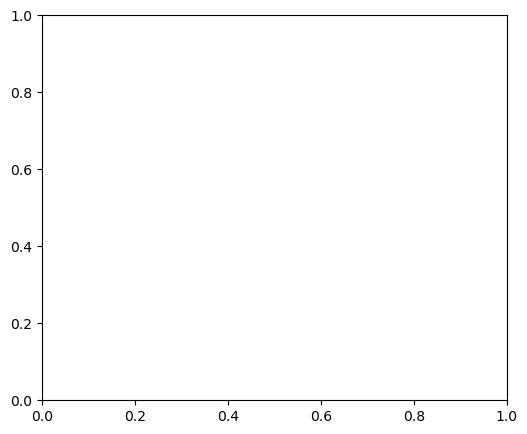

In [27]:
fig, ax1 = plt.subplots()
fig.set_size_inches(6,5)
att = 55

ax1.pcolormesh(freqs*1e-3,qubit_pow_array[:]-att,(np.transpose(mags[:,:])), 
            cmap='viridis', shading='gouraud', vmin=mags.min(), vmax=mags.max())
plt.ylabel('Qubit Drive Power (mdB)')
plt.xlabel('Frequency (GHz)')

ax2 = ax1.twinx()
ax2.pcolormesh(freqs*1e-3,qubit_pow_array[:],(np.transpose(mags[:,:])), 
            cmap='viridis', shading='gouraud', vmin=mags.min(), vmax=mags.max())
plt.ylabel('LO Power (mdB)')
plt.xlabel('Frequency (GHz)')
plt.show()

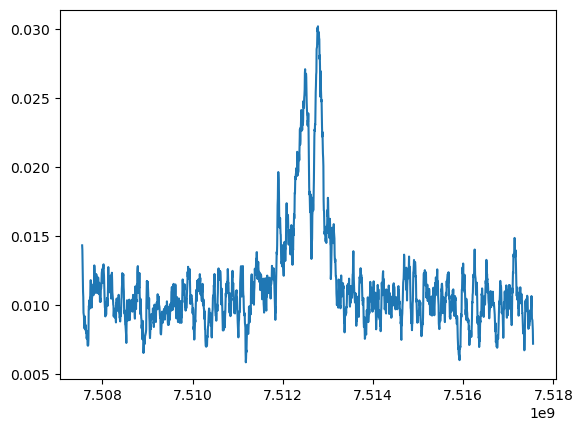

In [28]:
plt.plot(freqs, mags[14,:])